In [1]:
%pip install -r req.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler

# Data Preprocessing

In [53]:
dataframe = pd.read_csv("./datasets/Orientation-Based Analysis of 3D Printing Parameters and Quality Control/Orientation-Based Analysis of 3D Printing Parameters and Quality Control.csv")

# no truth labels for print failure or not so creating pseudo print failure label
dataframe['likely_failure'] = (
    (dataframe['Wair'] > 0) |
    (dataframe['Wair_partial'] > 0) |
    (dataframe['Farea'] < 10) |
    (dataframe['offset'] == 0) |
    (dataframe['Fwall'] == 0) |
    (dataframe['needsupport'] == 1)
).astype(int)  # 1 = likely to fail, 0 = normal

dataframe = dataframe.drop(columns=['model']) # remove model ID column

# standardize dataset
scaler = StandardScaler()
scaler.fit_transform(dataframe)

array([[ 1.17337599,  0.24151722,  1.72981954, ..., -0.35788909,
        -1.20407608,  0.6165148 ],
       [ 2.50294844,  0.24151722,  0.7040893 , ..., -0.35788909,
         0.83051231,  0.6165148 ],
       [ 2.50294844,  0.24151722,  0.7040893 , ..., -0.35788909,
         0.83051231,  0.6165148 ],
       ...,
       [-0.78113287, -0.90904202, -0.89158967, ..., -0.35746319,
         0.83051231,  0.6165148 ],
       [-0.89497564, -0.90904202, -0.80376296, ..., -0.35788909,
         0.83051231,  0.6165148 ],
       [-0.89497564, -0.90904202, -0.80376296, ..., -0.35788909,
         0.83051231,  0.6165148 ]])

In [54]:
dataframe['likely_failure'].value_counts()

likely_failure
1    442
0    168
Name: count, dtype: int64

In [56]:
X = dataframe.drop(columns=['likely_failure'])
y = dataframe['likely_failure']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training

In [98]:
# model parameters
n_estimators = 100 # num of trees
contamination = 0.5 # estimated expected percent of anomalies in dataset
model = IsolationForest(n_estimators=n_estimators, contamination=contamination, random_state=42)
model.fit(X_train)

,n_estimators,100
,max_samples,'auto'
,contamination,0.5
,max_features,1.0
,bootstrap,False
,n_jobs,None
,random_state,42
,verbose,0
,warm_start,False


# Data Visualization
Shows the amount of anomalies detected in the whole dataset.
- anomalies does not mean "print failure"
- only highlights prints with unusual configurations

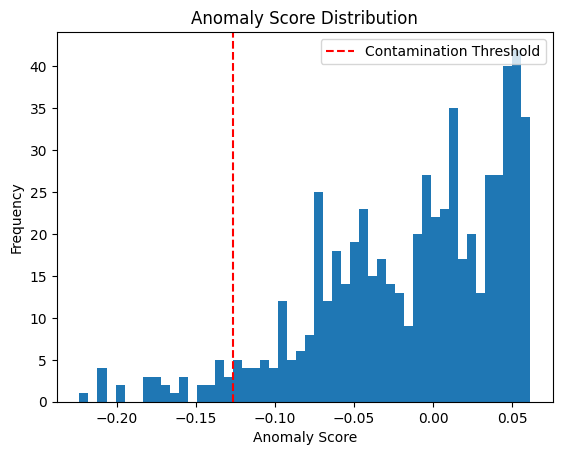

In [99]:
scores = model.decision_function(X)  # higher = more normal
plt.hist(scores, bins=50)
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution")
plt.axvline(np.percentile(scores, 5), color='red', linestyle='--', label='Contamination Threshold')
plt.legend()
plt.show()

# Model Evaluation

In [100]:
# Predict on test data
y_pred_test = model.predict(X_test)

# Convert from -1/1 to 1/0 (1 = anomaly = likely failure)
y_pred_test_binary = [1 if val == -1 else 0 for val in y_pred_test]

# Evaluate against proxy ground truth
print(classification_report(y_test, y_pred_test_binary))

              precision    recall  f1-score   support

           0       0.55      0.73      0.62        41
           1       0.84      0.69      0.76        81

    accuracy                           0.70       122
   macro avg       0.69      0.71      0.69       122
weighted avg       0.74      0.70      0.71       122

